# CQF Exam Three
## Question1 - What are voting classifiers in ensemble learning?
- A voting classifier is an ensemble method used to reduce the variance or increase the stability of the predictions as it requires many predictions from different models and predicts the class with majority vote of those predictions as a final prediction.
## Question2 - Explain the role of the regularization parameter C in a Support Vector Machine (SVM) model. How does varying C affect the model’s bias and variance trade-off?
- The parameter C in an SVM model is used to mitigate the bias-variance trade-off of the model as it introduces a relaxation in constructing decision boundaries when the data points of different classes cannot be easily separated. Higher the C, the lower variance we achieve while sacrificing the model's bias.

# Question3 - Follow the 7-steps to model building for your selected ticker

In [26]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas_ta as ta
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, precision_score, recall_score, f1_score
from scipy import stats

# Download daily data for (SPDR Gold Trust, Ticker: GLD) from yahoo finance module

In [2]:
import yfinance as yf
gld = yf.download("GLD",interval ='1d')
gld = gld.reset_index()
gld

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100
...,...,...,...,...,...,...,...
4762,2023-10-20,183.429993,185.229996,183.089996,183.589996,183.589996,12782800
4763,2023-10-23,183.509995,183.559998,182.710007,182.970001,182.970001,9479800
4764,2023-10-24,182.070007,183.399994,181.679993,182.949997,182.949997,6594000
4765,2023-10-25,183.419998,184.300003,182.039993,183.720001,183.720001,10087000


# Compute the returns to be used as momentum features and forward returns to derive the target (1 when tomorrow return >= 0.25% else 0)
Features to be used
- Log volume
- last 1-day return
- last 3-day return
- last 5-day return
- Candle stick patterns (but I will selectively choose only some patterns that yield statistically significant in predicting the future return only)

In [3]:
gld['3d_return'] = gld['Adj Close'].pct_change(3)
gld['3d_return_sign'] = gld['3d_return'].apply(lambda x: 0 if x <= 0 else 1)

gld['1d_return'] = gld['Adj Close'].pct_change(1)
gld['1d_return_sign'] = gld['1d_return'].apply(lambda x: 0 if x <= 0 else 1)
gld['forward_1d_return'] = gld['3d_return'].shift(-1)
gld['1d_target'] = gld['forward_1d_return'].apply(lambda x: 1 if x >=0.0025 else 0)

gld['5d_return'] = gld['Adj Close'].pct_change(5)
gld['5d_return_sign'] = gld['5d_return'].apply(lambda x: 0 if x <= 0 else 1)
gld['log_vol'] = np.log(gld['Volume'])
features= ['log_vol', '1d_return_sign', '1d_return', '3d_return_sign', '3d_return', '5d_return_sign', '5d_return']
targets = ['1d_target', '3d_target', '5d_target']
gld.head(60)

,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,1d_return,1d_return_sign,forward_1d_return,1d_target,5d_return,5d_return_sign,log_vol
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,NaN,1,NaN,1,NaN,0,NaN,1,15.605936
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,NaN,1,0.009013,1,NaN,0,NaN,1,16.271272
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,NaN,1,0.003796,1,0.008337,1,NaN,1,16.300084
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,0.008337,1,-0.004449,0,0.006029,1,NaN,1,14.968990
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,0.006029,1,0.006704,1,0.007564,1,NaN,1,15.624635
5,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700,0.007564,1,0.005327,1,0.014525,1,0.020505,1,14.946170
6,2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000,0.014525,1,0.002429,1,0.001554,0,0.013846,1,15.139664
7,2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200,0.001554,1,-0.006167,0,0.001987,0,0.003782,1,15.165452
8,2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500,0.001987,1,0.005762,1,-0.009912,0,0.014078,1,14.527234
9,2004-12-02,45.549999,45.570000,44.680000,44.950001,44.950001,6457800,-0.009912,0,-0.009476,0,0.010638,1,-0.002220,0,15.680799


In [4]:
gld.describe()#simple EDA on the data

,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,1d_return,1d_return_sign,forward_1d_return,1d_target,5d_return,5d_return_sign,log_vol
count,4767,4767.000000,4767.000000,4767.000000,4767.000000,4767.000000,4.767000e+03,4764.000000,4767.000000,4766.000000,4767.000000,4764.000000,4767.000000,4762.000000,4767.000000,4767.000000
mean,2014-05-08 22:38:26.356198912,121.728878,122.324596,121.086780,121.726069,121.726069,9.543447e+06,0.001072,0.530103,0.000361,0.526746,0.001072,0.467170,0.001786,0.544368,15.858553
min,2004-11-18 00:00:00,41.029999,41.360001,41.020000,41.259998,41.259998,3.193000e+05,-0.128955,0.000000,-0.087808,0.000000,-0.128955,0.000000,-0.139239,0.000000,12.673886
25%,2009-08-13 12:00:00,96.494999,97.065002,95.430000,96.195000,96.195000,5.283300e+06,-0.009169,0.000000,-0.005127,0.000000,-0.009169,0.000000,-0.012095,0.000000,15.480061
50%,2014-05-09 00:00:00,121.879997,122.300003,121.389999,121.800003,121.800003,7.912300e+06,0.001260,1.000000,0.000523,1.000000,0.001260,0.000000,0.002627,1.000000,15.883929
75%,2019-02-02 12:00:00,156.394997,157.354996,155.529999,156.495003,156.495003,1.173830e+07,0.011841,1.000000,0.006059,1.000000,0.011841,1.000000,0.016254,1.000000,16.278368
max,2023-10-26 00:00:00,193.740005,194.449997,192.520004,193.889999,193.889999,9.380420e+07,0.131171,1.000000,0.112905,1.000000,0.131171,1.000000,0.151442,1.000000,18.356720
std,NaN,38.789312,38.917278,38.639145,38.784779,38.784779,6.831191e+06,0.019084,0.499145,0.011140,0.499336,0.019084,0.498973,0.024652,0.498080,0.678326


# I used well-known candle stick patterns derived from the pandas_ta module as additional features

In [5]:
gld = pd.concat([gld, gld.ta.cdl_pattern(name="all")], axis=1)
gld

,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,1d_return,...,CDL_SPINNINGTOP,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,NaN,1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,NaN,1,0.009013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,NaN,1,0.003796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,0.008337,1,-0.004449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,0.006029,1,0.006704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,2023-10-20,183.429993,185.229996,183.089996,183.589996,183.589996,12782800,0.029727,1,0.002731,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4763,2023-10-23,183.509995,183.559998,182.710007,182.970001,182.970001,9479800,0.011611,1,-0.003377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4764,2023-10-24,182.070007,183.399994,181.679993,182.949997,182.949997,6594000,-0.000765,0,-0.000109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4765,2023-10-25,183.419998,184.300003,182.039993,183.720001,183.720001,10087000,0.000708,1,0.004209,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#get all the patterns available in pandas_ta module
all_indicators = list(gld.ta.cdl_pattern(name="all").columns)
all_indicators

['CDL_2CROWS',
 'CDL_3BLACKCROWS',
 'CDL_3INSIDE',
 'CDL_3LINESTRIKE',
 'CDL_3OUTSIDE',
 'CDL_3STARSINSOUTH',
 'CDL_3WHITESOLDIERS',
 'CDL_ABANDONEDBABY',
 'CDL_ADVANCEBLOCK',
 'CDL_BELTHOLD',
 'CDL_BREAKAWAY',
 'CDL_CLOSINGMARUBOZU',
 'CDL_CONCEALBABYSWALL',
 'CDL_COUNTERATTACK',
 'CDL_DARKCLOUDCOVER',
 'CDL_DOJI_10_0.1',
 'CDL_DOJISTAR',
 'CDL_DRAGONFLYDOJI',
 'CDL_ENGULFING',
 'CDL_EVENINGDOJISTAR',
 'CDL_EVENINGSTAR',
 'CDL_GAPSIDESIDEWHITE',
 'CDL_GRAVESTONEDOJI',
 'CDL_HAMMER',
 'CDL_HANGINGMAN',
 'CDL_HARAMI',
 'CDL_HARAMICROSS',
 'CDL_HIGHWAVE',
 'CDL_HIKKAKE',
 'CDL_HIKKAKEMOD',
 'CDL_HOMINGPIGEON',
 'CDL_IDENTICAL3CROWS',
 'CDL_INNECK',
 'CDL_INSIDE',
 'CDL_INVERTEDHAMMER',
 'CDL_KICKING',
 'CDL_KICKINGBYLENGTH',
 'CDL_LADDERBOTTOM',
 'CDL_LONGLEGGEDDOJI',
 'CDL_LONGLINE',
 'CDL_MARUBOZU',
 'CDL_MATCHINGLOW',
 'CDL_MATHOLD',
 'CDL_MORNINGDOJISTAR',
 'CDL_MORNINGSTAR',
 'CDL_ONNECK',
 'CDL_PIERCING',
 'CDL_RICKSHAWMAN',
 'CDL_RISEFALL3METHODS',
 'CDL_SEPARATINGLINES',
 'CDL_SH

In [7]:
#find indicators that are quite active
useable_indicators = []
for i in all_indicators:
    if len(gld[gld[i]!=0]) >= 100:
        useable_indicators.append(i)
useable_indicators

['CDL_3OUTSIDE',
 'CDL_BELTHOLD',
 'CDL_CLOSINGMARUBOZU',
 'CDL_DOJI_10_0.1',
 'CDL_DOJISTAR',
 'CDL_ENGULFING',
 'CDL_HAMMER',
 'CDL_HANGINGMAN',
 'CDL_HARAMI',
 'CDL_HARAMICROSS',
 'CDL_HIGHWAVE',
 'CDL_HIKKAKE',
 'CDL_INSIDE',
 'CDL_LONGLEGGEDDOJI',
 'CDL_LONGLINE',
 'CDL_MARUBOZU',
 'CDL_RICKSHAWMAN',
 'CDL_SHORTLINE',
 'CDL_SPINNINGTOP']

# More EDA and feature engineering
## I used unofficial hypothesis testing (with student-t distribution) to check if the mean of the returns when a particular pattern is triggered is statistically significance. ( to make it simple I use the critical value at t-value = 1.96 regardless of the DoF of the samples)

In [9]:
tmp_gld_data = gld[gld['Date'] <= '2019'].copy()#use only data in the training period to avoid overfitting
for i in useable_indicators:
    all_values = tmp_gld_data[i].unique()
    tmp_df = tmp_gld_data[[i, 'forward_1d_return']]
    tmp_mean = tmp_df.groupby(i, as_index=False).mean().set_index(i)
    tmp_n = tmp_df.groupby(i, as_index=False).count().set_index(i)
    tmp_std = tmp_df.groupby(i, as_index=False).std().set_index(i)
    tmp_se = tmp_std/np.sqrt(tmp_n)
    tmp_t = tmp_mean/tmp_se
    tmp_mean2 = tmp_mean.where(tmp_t.abs() > 1.96, '-')
    if np.max(np.abs(tmp_t[tmp_t.index != 0]['forward_1d_return'])) >= 1.96:
        features.append(i)
        print(i)
        print("max_ret:", tmp_mean.max().max(), "min_ret:", tmp_mean.min().min())
        display(tmp_mean2)
        display(tmp_n)
        display(tmp_t)
        print()
        print('--------------------------------------------')
#     break

CDL_3OUTSIDE
max_ret: 0.015645559130383048 min_ret: -0.018673462333922874


,forward_1d_return
CDL_3OUTSIDE,
-100.0,-0.018673
0.0,0.001121
100.0,0.015646


,forward_1d_return
CDL_3OUTSIDE,
-100.0,46
0.0,3462
100.0,43


,forward_1d_return
CDL_3OUTSIDE,
-100.0,-8.768302
0.0,3.337134
100.0,6.558265



--------------------------------------------
CDL_BELTHOLD
max_ret: 0.01005336730083249 min_ret: -0.011066939311615835


,forward_1d_return
CDL_BELTHOLD,
-100.0,-0.011067
0.0,0.001396
100.0,0.010053


,forward_1d_return
CDL_BELTHOLD,
-100.0,293
0.0,2982
100.0,276


,forward_1d_return
CDL_BELTHOLD,
-100.0,-9.477348
0.0,3.910449
100.0,9.567665



--------------------------------------------
CDL_CLOSINGMARUBOZU
max_ret: 0.01100639079362532 min_ret: -0.009013145678681014


,forward_1d_return
CDL_CLOSINGMARUBOZU,
-100.0,-0.009013
0.0,0.000858
100.0,0.011006


,forward_1d_return
CDL_CLOSINGMARUBOZU,
-100.0,145
0.0,3201
100.0,205


,forward_1d_return
CDL_CLOSINGMARUBOZU,
-100.0,-5.154829
0.0,2.478199
100.0,8.338094



--------------------------------------------
CDL_DOJISTAR
max_ret: 0.016074623490491758 min_ret: -0.011264329874492695


,forward_1d_return
CDL_DOJISTAR,
-100.0,0.016075
0.0,0.000924
100.0,-0.011264


,forward_1d_return
CDL_DOJISTAR,
-100.0,58
0.0,3455
100.0,38


,forward_1d_return
CDL_DOJISTAR,
-100.0,9.817710
0.0,2.734242
100.0,-4.274157



--------------------------------------------
CDL_ENGULFING
max_ret: 0.006079429607441564 min_ret: -0.004693182131989337


,forward_1d_return
CDL_ENGULFING,
-100.0,-0.004693
0.0,0.001064
100.0,0.006079


,forward_1d_return
CDL_ENGULFING,
-100.0,89
0.0,3376
100.0,86


,forward_1d_return
CDL_ENGULFING,
-100.0,-2.803876
0.0,3.084409
100.0,3.904798



--------------------------------------------
CDL_HAMMER
max_ret: 0.001245913968836662 min_ret: -0.007128847119905078


,forward_1d_return
CDL_HAMMER,
0.0,0.001246
100.0,-0.007129


,forward_1d_return
CDL_HAMMER,
0.0,3464
100.0,87


,forward_1d_return
CDL_HAMMER,
0.0,3.677844
100.0,-4.748591



--------------------------------------------
CDL_HANGINGMAN
max_ret: 0.00844987353680318 min_ret: 0.0008216147253883823


,forward_1d_return
CDL_HANGINGMAN,
-100.0,0.008450
0.0,0.000822


,forward_1d_return
CDL_HANGINGMAN,
-100.0,102
0.0,3449


,forward_1d_return
CDL_HANGINGMAN,
-100.0,6.153350
0.0,2.416928



--------------------------------------------
CDL_HARAMI
max_ret: 0.008462870913847743 min_ret: -0.010338577812936093


,forward_1d_return
CDL_HARAMI,
-100.0,0.008463
0.0,0.001186
100.0,-0.010339


,forward_1d_return
CDL_HARAMI,
-100.0,138
0.0,3281
100.0,132


,forward_1d_return
CDL_HARAMI,
-100.0,6.169592
0.0,3.417395
100.0,-6.620798



--------------------------------------------
CDL_HARAMICROSS
max_ret: 0.012758149064343203 min_ret: -0.010239420120314117


,forward_1d_return
CDL_HARAMICROSS,
-100.0,0.012758
0.0,0.001052
100.0,-0.010239


,forward_1d_return
CDL_HARAMICROSS,
-100.0,43
0.0,3460
100.0,48


,forward_1d_return
CDL_HARAMICROSS,
-100.0,4.796556
0.0,3.125241
100.0,-3.473587



--------------------------------------------
CDL_HIKKAKE
max_ret: 0.016151145536264042 min_ret: -0.014693269283121221


,forward_1d_return
CDL_HIKKAKE,
-200.0,-0.014693
-100.0,0.009096
0.0,0.001104
100.0,-0.009312
200.0,0.016151


,forward_1d_return
CDL_HIKKAKE,
-200.0,52
-100.0,197
0.0,3076
100.0,172
200.0,54


,forward_1d_return
CDL_HIKKAKE,
-200.0,-5.742186
-100.0,7.797403
0.0,3.100804
100.0,-6.504032
200.0,7.623541



--------------------------------------------
CDL_LONGLINE
max_ret: 0.01143231738692245 min_ret: -0.008563152874281322


,forward_1d_return
CDL_LONGLINE,
-100.0,-0.008563
0.0,0.000767
100.0,0.011432


,forward_1d_return
CDL_LONGLINE,
-100.0,281
0.0,2933
100.0,337


,forward_1d_return
CDL_LONGLINE,
-100.0,-7.833745
0.0,2.126662
100.0,10.892149



--------------------------------------------
CDL_MARUBOZU
max_ret: 0.013423027783082169 min_ret: -0.01296327185326258


,forward_1d_return
CDL_MARUBOZU,
-100.0,-0.012963
0.0,0.000995
100.0,0.013423


,forward_1d_return
CDL_MARUBOZU,
-100.0,49
0.0,3434
100.0,68


,forward_1d_return
CDL_MARUBOZU,
-100.0,-4.102773
0.0,2.956731
100.0,6.420470



--------------------------------------------
CDL_SHORTLINE
max_ret: 0.0055983391483206005 min_ret: 0.0005827613462534072


,forward_1d_return
CDL_SHORTLINE,
-100.0,-
0.0,-
100.0,0.005598


,forward_1d_return
CDL_SHORTLINE,
-100.0,245
0.0,3029
100.0,277


,forward_1d_return
CDL_SHORTLINE,
-100.0,1.619518
0.0,1.581787
100.0,5.066720



--------------------------------------------
CDL_SPINNINGTOP
max_ret: 0.0031177913760217046 min_ret: 0.00010402773911800444


,forward_1d_return
CDL_SPINNINGTOP,
-100.0,-
0.0,0.000855
100.0,0.003118


,forward_1d_return
CDL_SPINNINGTOP,
-100.0,425
0.0,2694
100.0,432


,forward_1d_return
CDL_SPINNINGTOP,
-100.0,0.121625
0.0,2.208737
100.0,3.197083



--------------------------------------------


In [15]:
#all the features that I am going to use
features

['log_vol',
 '1d_return_sign',
 '1d_return',
 '3d_return_sign',
 '3d_return',
 '5d_return_sign',
 '5d_return',
 'CDL_3OUTSIDE',
 'CDL_BELTHOLD',
 'CDL_CLOSINGMARUBOZU',
 'CDL_DOJISTAR',
 'CDL_ENGULFING',
 'CDL_HAMMER',
 'CDL_HANGINGMAN',
 'CDL_HARAMI',
 'CDL_HARAMICROSS',
 'CDL_HIKKAKE',
 'CDL_LONGLINE',
 'CDL_MARUBOZU',
 'CDL_SHORTLINE',
 'CDL_SPINNINGTOP']

In [16]:
gld = gld.dropna()

In [17]:
gld

,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,1d_return,...,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS,year-month
5,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700,0.007564,1,0.005327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
6,2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000,0.014525,1,0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
7,2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200,0.001554,1,-0.006167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
8,2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500,0.001987,1,0.005762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
9,2004-12-02,45.549999,45.570000,44.680000,44.950001,44.950001,6457800,-0.009912,0,-0.009476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,2023-10-19,181.039993,183.429993,180.820007,183.089996,183.089996,13406600,0.028827,1,0.012274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4762,2023-10-20,183.429993,185.229996,183.089996,183.589996,183.589996,12782800,0.029727,1,0.002731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4763,2023-10-23,183.509995,183.559998,182.710007,182.970001,182.970001,9479800,0.011611,1,-0.003377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2023-10
4764,2023-10-24,182.070007,183.399994,181.679993,182.949997,182.949997,6594000,-0.000765,0,-0.000109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10


In [18]:
gld['year-month'] = gld['Date'].dt.strftime("%Y-%m")
gld

,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,1d_return,...,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS,year-month
5,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700,0.007564,1,0.005327,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
6,2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000,0.014525,1,0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
7,2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200,0.001554,1,-0.006167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
8,2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500,0.001987,1,0.005762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
9,2004-12-02,45.549999,45.570000,44.680000,44.950001,44.950001,6457800,-0.009912,0,-0.009476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4761,2023-10-19,181.039993,183.429993,180.820007,183.089996,183.089996,13406600,0.028827,1,0.012274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4762,2023-10-20,183.429993,185.229996,183.089996,183.589996,183.589996,12782800,0.029727,1,0.002731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4763,2023-10-23,183.509995,183.559998,182.710007,182.970001,182.970001,9479800,0.011611,1,-0.003377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2023-10
4764,2023-10-24,182.070007,183.399994,181.679993,182.949997,182.949997,6594000,-0.000765,0,-0.000109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10


In [19]:
year_months = sorted(gld['year-month'].unique())
year_months

['2004-11',
 '2004-12',
 '2005-01',
 '2005-02',
 '2005-03',
 '2005-04',
 '2005-05',
 '2005-06',
 '2005-07',
 '2005-08',
 '2005-09',
 '2005-10',
 '2005-11',
 '2005-12',
 '2006-01',
 '2006-02',
 '2006-03',
 '2006-04',
 '2006-05',
 '2006-06',
 '2006-07',
 '2006-08',
 '2006-09',
 '2006-10',
 '2006-11',
 '2006-12',
 '2007-01',
 '2007-02',
 '2007-03',
 '2007-04',
 '2007-05',
 '2007-06',
 '2007-07',
 '2007-08',
 '2007-09',
 '2007-10',
 '2007-11',
 '2007-12',
 '2008-01',
 '2008-02',
 '2008-03',
 '2008-04',
 '2008-05',
 '2008-06',
 '2008-07',
 '2008-08',
 '2008-09',
 '2008-10',
 '2008-11',
 '2008-12',
 '2009-01',
 '2009-02',
 '2009-03',
 '2009-04',
 '2009-05',
 '2009-06',
 '2009-07',
 '2009-08',
 '2009-09',
 '2009-10',
 '2009-11',
 '2009-12',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '20

In [20]:
def getnerate_ts_split(sorted_ts_list, 
                       num_month_train = 24, 
                       skip_month = 1,
                       num_month_test = 2):
    return sorted_ts_list[: num_month_train] , sorted_ts_list[num_month_train + skip_month: num_month_train + skip_month + num_month_test]

In [21]:
gld = gld.reset_index(drop=True).reset_index().rename(columns={'index': 'ind'})
gld

,ind,Date,Open,High,Low,Close,Adj Close,Volume,3d_return,3d_return_sign,...,CDL_STALLEDPATTERN,CDL_STICKSANDWICH,CDL_TAKURI,CDL_TASUKIGAP,CDL_THRUSTING,CDL_TRISTAR,CDL_UNIQUE3RIVER,CDL_UPSIDEGAP2CROWS,CDL_XSIDEGAP3METHODS,year-month
0,0,2004-11-26,45.250000,45.599998,45.060001,45.290001,45.290001,3097700,0.007564,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
1,1,2004-11-29,45.099998,45.500000,45.080002,45.400002,45.400002,3759000,0.014525,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
2,2,2004-11-30,45.369999,45.410000,44.820000,45.119999,45.119999,3857200,0.001554,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11
3,3,2004-12-01,45.279999,45.590000,45.259998,45.380001,45.380001,2037500,0.001987,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
4,4,2004-12-02,45.549999,45.570000,44.680000,44.950001,44.950001,6457800,-0.009912,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756,4756,2023-10-19,181.039993,183.429993,180.820007,183.089996,183.089996,13406600,0.028827,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4757,4757,2023-10-20,183.429993,185.229996,183.089996,183.589996,183.589996,12782800,0.029727,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10
4758,4758,2023-10-23,183.509995,183.559998,182.710007,182.970001,182.970001,9479800,0.011611,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,2023-10
4759,4759,2023-10-24,182.070007,183.399994,181.679993,182.949997,182.949997,6594000,-0.000765,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-10


# I apply rolling window with 1 month skip between training set and testset data to avoid data leakage.

In [22]:
num_month_train = 12*15#15 years training
skip_month = 1#1month skip
num_month_test = 2#2months in testset

num_month_train_cv = num_month_train//2
skip_month_cv = num_month_test

cv = 3

report = {'pred_year_month' : [], 'prediction_length': [], 'precision': [], 'recall': [], 'f1':[]}
target = '1d_target'
for i in range(len(year_months) - num_month_train - num_month_test):
    tmp_cv = []
    tr_year_month, te_year_month = getnerate_ts_split(year_months[i:], 
                       num_month_train = num_month_train, 
                       skip_month = skip_month,
                       num_month_test = num_month_test)
    tmp_tr = gld[gld['year-month'].isin(tr_year_month)].copy().reset_index(drop=True)
    tmp_te = gld[gld['year-month'].isin(te_year_month)].copy().reset_index(drop=True)
    X_tr = tmp_tr[features]
    X_te = tmp_te[features]
    y_tr = tmp_tr[target]
    y_te = tmp_te[target]
    
    #I implemented a simple timeseries cross validation in order to tune and find the by hyper parameters.
    #1-month skip is also used in the cross validation
    for j in range(cv):
        tr_cv, te_cv = getnerate_ts_split(tr_year_month[j* skip_month_cv:], 
                                          num_month_train = num_month_train_cv,
                                          skip_month = skip_month,
                                          num_month_test = num_month_test)
        tmp_cv_x_tr = tmp_tr[tmp_tr['year-month'].isin(tr_cv)].index
        tmp_cv_x_te = tmp_tr[tmp_tr['year-month'].isin(te_cv)].index
        tmp_cv.append((tmp_cv_x_tr, tmp_cv_x_te))
    print('tr_year_month')
    print(tr_year_month)
    print('te_year_month')
    print(te_year_month)
    
    
    
    
    model = RandomForestClassifier()
    #Tuning parameters to maximize the average macro f1-score
    parameters = {'n_estimators':[100, 300, 500],#Varying the number of trees
                  'max_depth':[2, 4, 8, 16],#Varying the max_depth of each tree
                  'class_weight': ['balanced']#Class weight is always set to "balanced to mitigate data imbalance in some training set and testset.
                 }
    clf = GridSearchCV(model, parameters, cv=tmp_cv, scoring = 'f1_macro')
    clf.fit(X_tr, y_tr)
    confusion_matrix, auc
    print('Best params:', clf.best_params_)
    y_pred = clf.predict(X_tr)
    y_pred_proba = clf.predict_proba(X_tr)[:,1]
    print('*******************')
    print('Training set performance')
    print('*******************')
    print('Confusion matrix:')
    print(confusion_matrix(y_tr, y_pred))
    print('Classification report:')
    print(classification_report(y_tr, y_pred))
    fpr, tpr, thresholds = roc_curve(y_tr, y_pred_proba, pos_label=1)
    print('AUC:', auc(fpr, tpr))
    print()
    y_pred = clf.predict(X_te)
    y_pred_proba = clf.predict_proba(X_te)[:,1]
    print('*******************')
    print('Testset performance')
    print('*******************')
    print('Confusion matrix:')
    print(confusion_matrix(y_te, y_pred))
    print('Classification report:')
    print(classification_report(y_te, y_pred))
    fpr, tpr, thresholds = roc_curve(y_te, y_pred_proba, pos_label=1)
    print('AUC:', auc(fpr, tpr))
    print()
    print('---------------------------------------------------------------')
    report['pred_year_month'].append(te_year_month[0])
    report['prediction_length'].append(num_month_test)
    report['precision'].append(precision_score(y_te, y_pred, average=None)[1])
    report['recall'].append(recall_score(y_te, y_pred, average=None)[1])
    report['f1'].append(f1_score(y_te, y_pred, average=None)[1])

tr_year_month
['2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-

Best params: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1612  383]
 [ 340 1440]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1995
           1       0.79      0.81      0.80      1780

    accuracy                           0.81      3775
   macro avg       0.81      0.81      0.81      3775
weighted avg       0.81      0.81      0.81      3775

AUC: 0.8931129790769058

*******************
Testset performance
*******************
Confusion matrix:
[[18  5]
 [ 3 15]]
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.75      0.83      0.79        18

    accuracy                           0.80        41
   macro avg       0.80      0.81      0.80        41
weighted avg       0.81      0.80      0.81 

Best params: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1479  512]
 [ 430 1355]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1991
           1       0.73      0.76      0.74      1785

    accuracy                           0.75      3776
   macro avg       0.75      0.75      0.75      3776
weighted avg       0.75      0.75      0.75      3776

AUC: 0.8359252490549206

*******************
Testset performance
*******************
Confusion matrix:
[[12  8]
 [ 7 15]]
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.60      0.62        20
           1       0.65      0.68      0.67        22

    accuracy                           0.64        42
   macro avg       0.64      0.64      0.64        42
weighted avg       0.64      0.64      0.64 

Best params: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1488  497]
 [ 444 1346]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1985
           1       0.73      0.75      0.74      1790

    accuracy                           0.75      3775
   macro avg       0.75      0.75      0.75      3775
weighted avg       0.75      0.75      0.75      3775

AUC: 0.8350367983338727

*******************
Testset performance
*******************
Confusion matrix:
[[15  6]
 [ 6 15]]
Classification report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.71      0.71      0.71        21

    accuracy                           0.71        42
   macro avg       0.71      0.71      0.71        42
weighted avg       0.71      0.71      0.71 

Best params: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1458  520]
 [ 457 1340]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1978
           1       0.72      0.75      0.73      1797

    accuracy                           0.74      3775
   macro avg       0.74      0.74      0.74      3775
weighted avg       0.74      0.74      0.74      3775

AUC: 0.8216362176484455

*******************
Testset performance
*******************
Confusion matrix:
[[13  4]
 [ 4 21]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.84      0.84      0.84        25

    accuracy                           0.81        42
   macro avg       0.80      0.80      0.80        42
weighted avg       0.81      0.81      0.81 

Best params: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1597  387]
 [ 348 1444]]
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1984
           1       0.79      0.81      0.80      1792

    accuracy                           0.81      3776
   macro avg       0.80      0.81      0.81      3776
weighted avg       0.81      0.81      0.81      3776

AUC: 0.8900962161578341

*******************
Testset performance
*******************
Confusion matrix:
[[22  5]
 [ 6  9]]
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        27
           1       0.64      0.60      0.62        15

    accuracy                           0.74        42
   macro avg       0.71      0.71      0.71        42
weighted avg       0.73      0.74      0.74 

Best params: {'class_weight': 'balanced', 'max_depth': 8, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1605  395]
 [ 331 1444]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2000
           1       0.79      0.81      0.80      1775

    accuracy                           0.81      3775
   macro avg       0.81      0.81      0.81      3775
weighted avg       0.81      0.81      0.81      3775

AUC: 0.8898594366197183

*******************
Testset performance
*******************
Confusion matrix:
[[14  9]
 [ 4 15]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.62      0.79      0.70        19

    accuracy                           0.69        42
   macro avg       0.70      0.70      0.69        42
weighted avg       0.71      0.69      0.69 

Best params: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1472  529]
 [ 426 1348]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2001
           1       0.72      0.76      0.74      1774

    accuracy                           0.75      3775
   macro avg       0.75      0.75      0.75      3775
weighted avg       0.75      0.75      0.75      3775

AUC: 0.833601237712598

*******************
Testset performance
*******************
Confusion matrix:
[[17  7]
 [ 8 11]]
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        24
           1       0.61      0.58      0.59        19

    accuracy                           0.65        43
   macro avg       0.65      0.64      0.64        43
weighted avg       0.65      0.65      0.65  

Best params: {'class_weight': 'balanced', 'max_depth': 4, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1486  513]
 [ 439 1338]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1999
           1       0.72      0.75      0.74      1777

    accuracy                           0.75      3776
   macro avg       0.75      0.75      0.75      3776
weighted avg       0.75      0.75      0.75      3776

AUC: 0.8325178346066675

*******************
Testset performance
*******************
Confusion matrix:
[[17  9]
 [ 5 12]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.65      0.71        26
           1       0.57      0.71      0.63        17

    accuracy                           0.67        43
   macro avg       0.67      0.68      0.67        43
weighted avg       0.69      0.67      0.68 

Best params: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1457  547]
 [ 448 1325]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      2004
           1       0.71      0.75      0.73      1773

    accuracy                           0.74      3777
   macro avg       0.74      0.74      0.74      3777
weighted avg       0.74      0.74      0.74      3777

AUC: 0.8186908754403206

*******************
Testset performance
*******************
Confusion matrix:
[[10  5]
 [ 3 24]]
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.83      0.89      0.86        27

    accuracy                           0.81        42
   macro avg       0.80      0.78      0.79        42
weighted avg       0.81      0.81      0.81 

Best params: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1480  520]
 [ 465 1313]]
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2000
           1       0.72      0.74      0.73      1778

    accuracy                           0.74      3778
   macro avg       0.74      0.74      0.74      3778
weighted avg       0.74      0.74      0.74      3778

AUC: 0.8207096456692914

*******************
Testset performance
*******************
Confusion matrix:
[[23  6]
 [ 6  7]]
Classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.54      0.54      0.54        13

    accuracy                           0.71        42
   macro avg       0.67      0.67      0.67        42
weighted avg       0.71      0.71      0.71 

Best params: {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1941   67]
 [  72 1697]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2008
           1       0.96      0.96      0.96      1769

    accuracy                           0.96      3777
   macro avg       0.96      0.96      0.96      3777
weighted avg       0.96      0.96      0.96      3777

AUC: 0.9948625509268747

*******************
Testset performance
*******************
Confusion matrix:
[[20  9]
 [ 9  6]]
Classification report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        29
           1       0.40      0.40      0.40        15

    accuracy                           0.59        44
   macro avg       0.54      0.54      0.54        44
weighted avg       0.59      0.59      0.59

Best params: {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 300}
*******************
Training set performance
*******************
Confusion matrix:
[[1954   74]
 [  60 1690]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2028
           1       0.96      0.97      0.96      1750

    accuracy                           0.96      3778
   macro avg       0.96      0.96      0.96      3778
weighted avg       0.96      0.96      0.96      3778

AUC: 0.9952042828965906

*******************
Testset performance
*******************
Confusion matrix:
[[15  3]
 [ 5 19]]
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.86      0.79      0.83        24

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81

Best params: {'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 500}
*******************
Training set performance
*******************
Confusion matrix:
[[1968   67]
 [  57 1685]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2035
           1       0.96      0.97      0.96      1742

    accuracy                           0.97      3777
   macro avg       0.97      0.97      0.97      3777
weighted avg       0.97      0.97      0.97      3777

AUC: 0.9957463673881584

*******************
Testset performance
*******************
Confusion matrix:
[[21  4]
 [ 6 11]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        25
           1       0.73      0.65      0.69        17

    accuracy                           0.76        42
   macro avg       0.76      0.74      0.75        42
weighted avg       0.76      0.76      0.76

Best params: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 100}
*******************
Training set performance
*******************
Confusion matrix:
[[1483  556]
 [ 417 1322]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2039
           1       0.70      0.76      0.73      1739

    accuracy                           0.74      3778
   macro avg       0.74      0.74      0.74      3778
weighted avg       0.75      0.74      0.74      3778

AUC: 0.8250020235088009

*******************
Testset performance
*******************
Confusion matrix:
[[25  7]
 [ 5  6]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.46      0.55      0.50        11

    accuracy                           0.72        43
   macro avg       0.65      0.66      0.65        43
weighted avg       0.74      0.72      0.73 

Best params: {'class_weight': 'balanced', 'max_depth': 2, 'n_estimators': 500}
*******************
Training set performance
*******************
Confusion matrix:
[[1497  553]
 [ 432 1294]]
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2050
           1       0.70      0.75      0.72      1726

    accuracy                           0.74      3776
   macro avg       0.74      0.74      0.74      3776
weighted avg       0.74      0.74      0.74      3776

AUC: 0.8236722437328661

*******************
Testset performance
*******************
Confusion matrix:
[[26  5]
 [ 3  9]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.64      0.75      0.69        12

    accuracy                           0.81        43
   macro avg       0.77      0.79      0.78        43
weighted avg       0.83      0.81      0.82 

In [23]:
report = pd.DataFrame(report)
report

,pred_year_month,prediction_length,precision,recall,f1
0,2019-12,2,0.733333,0.785714,0.758621
1,2020-01,2,0.739130,0.772727,0.755556
2,2020-02,2,0.750000,0.833333,0.789474
3,2020-03,2,0.761905,0.800000,0.780488
4,2020-04,2,0.684211,0.590909,0.634146
5,2020-05,2,0.652174,0.681818,0.666667
6,2020-06,2,0.800000,0.857143,0.827586
7,2020-07,2,0.793103,0.821429,0.807018
8,2020-08,2,0.714286,0.714286,0.714286
9,2020-09,2,0.588235,0.625000,0.606061


mean_precision_confidence_interval @ 99.0% confidence level: [0.6477240140133317, 0.7402612971286592]
mean_recall_confidence_interval @ 99.0% confidence level: [0.6716608407865376, 0.7658003799099773]


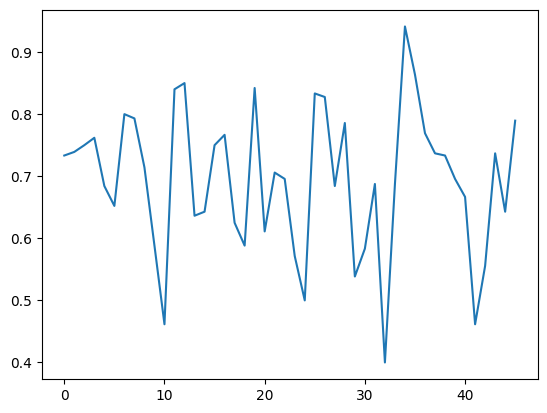

In [51]:
alpha=0.01
for i in ['precision']
plt.plot(report['precision'], label=)


precision_confidence_interval = [
                                 report['precision'].mean() - stats.t.ppf(1-alpha/2, len(report) - 1) * report['precision'].std() / np.sqrt(len(report)),
                                 report['precision'].mean() + stats.t.ppf(1-alpha/2, len(report) - 1) * report['precision'].std() / np.sqrt(len(report)),
                                ]
print(f"mean_precision_confidence_interval @ {(1 - alpha)*100}% confidence level:", precision_confidence_interval)

recall_confidence_interval = [
                                 report['recall'].mean() - stats.t.ppf(1-alpha/2, len(report) - 1) * report['recall'].std() / np.sqrt(len(report)),
                                 report['recall'].mean() + stats.t.ppf(1-alpha/2, len(report) - 1) * report['recall'].std() / np.sqrt(len(report)),
                                ]
print(f"mean_recall_confidence_interval @ {(1 - alpha)*100}% confidence level:", recall_confidence_interval)

# Final discussion
- With the confidence interval of the mean of precision shown above, the model is promissing in generating real profits, but still requires further investigation.
- Based on the feature engineering and EDA of the selected candle stick patterns, the results of the model with rolling window training aligns with the hypothesis tests that the patterns have some predictive power in predicting 1-day forward return.
- The reason I consider only the precision